# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

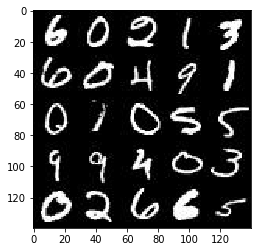

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

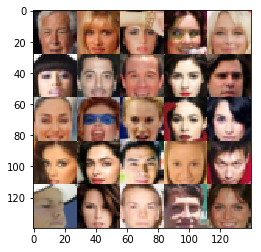

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_dim = (image_width, image_height, image_channels)
    
    # Real images placeholder
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim))
    
    # Generator input placeholder
    z = tf.placeholder(tf.float32, (None, z_dim))
    
    # Learning rate
    learning_rate = tf.placeholder(tf.float32, shape=())
    
    return inputs_real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
     
        # First convolutional layer - 14 x 14 x 64
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1r = tf.maximum(alpha * conv1, conv1)
        
        # Second convolutional layer - 7 x 7 x 128
        conv2 = tf.layers.conv2d(conv1r, 128, 5, strides=2, padding='same')
        conv2n = tf.layers.batch_normalization(conv2, training=True)
        conv2r = tf.maximum(alpha * conv2n, conv2n)
        
        # Third convolutional layer - 4 x 4 x 256
        conv3 = tf.layers.conv2d(conv2r, 256, 5, strides=2, padding='same')
        conv3n = tf.layers.batch_normalization(conv3, training=True)
        conv3r = tf.maximum(alpha * conv3n, conv3n)
        
        # Fourth convolutional layer - 2 x 2 x 512
        conv4 = tf.layers.conv2d(conv3r, 512, 5, strides=2, padding='same')
        conv4n = tf.layers.batch_normalization(conv4, training=True)
        conv4r = tf.maximum(alpha * conv4n, conv4n)
                
        # Reshape output for the final layer
        reshape = tf.reshape(conv4r,(-1, 8 * 64 * 2 * 2))
        
        # Logits
        logits = tf.layers.dense(reshape, 1)
        
        # Output
        out = tf.sigmoid(logits)
     

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse= not is_train):
        
        # Dense layer
        d = tf.layers.dense(z, 16 * 32 * 3 * 3)
        dr = tf.reshape(d, (-1, 3, 3, 16 * 32))
        drn = tf.layers.batch_normalization(dr, training=is_train)
        drnr = tf.maximum(alpha * drn, drn)
        
        # First transpose convolution - 7 x 7 x 128
        c1 = tf.layers.conv2d_transpose(drnr, 128, 3, strides=2, padding='valid')
        c1n = tf.layers.batch_normalization(c1, training=is_train)
        c1nr = tf.maximum(alpha * c1n, c1n)
        
        # Second transpose convolution - 14 x 14 x 64 
        c2 = tf.layers.conv2d_transpose(c1nr, 64, 5, strides=2, padding='same')
        c2n = tf.layers.batch_normalization(c2, training=is_train)
        c2nr = tf.maximum(alpha * c2n, c2n)
        
        # Third transpose convolution - 28 x 28 x 32
        c3 = tf.layers.conv2d_transpose(c2nr, 32, 5, strides=2, padding='same')
        c3n = tf.layers.batch_normalization(c3, training=is_train)
        c3nr = tf.maximum(alpha * c3n, c3n)
        
        # Fourth transpose convolution - 28 x 28 x out_channel_dim
        c4 = tf.layers.conv2d_transpose(c3nr, out_channel_dim, 5, strides=1, padding='same')
        
        # Output
        out = tf.tanh(c4)        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # Real images from discriminator
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    
    # Fake images from discriminator
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Discriminator real images loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    
    # Discriminator fake images loss
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # Discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Trainable variables
    t_vars = tf.trainable_variables()
    
    # Trainable discriminator variables
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Trainable generator variables
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Generator update
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    # Optimizers
    with tf.control_dependencies(gen_updates):
        
        # Train optimizer for Discriminator
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        # Train optimizer for Generator
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
   # Number of color channels
    _, image_w, image_h, n_channels = data_shape
    
    # Model input
    img, z, lr = model_inputs(image_w, image_h, n_channels, z_dim)
    
    # Losses
    d_loss, g_loss = model_loss(img, z, n_channels)
    
    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            # Set initial steps and sums
            steps = 0
            d_loss_sum = 0
            g_loss_sum = 0
            batch_count = 0
            
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_count += 1
                batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={img: batch_images, z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z: batch_z, lr: learning_rate})

                # Update loss sums
                d_loss_sum += d_loss.eval({z: batch_z, img: batch_images})
                g_loss_sum += g_loss.eval({z: batch_z})

                # Print the losses
                if steps%20 == 0:
                    
                    # Generator output
                    show_generator_output(sess, 16, z, n_channels, data_image_mode)
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Avg. Discriminator Loss: {:.4f}...".format(d_loss_sum / batch_count),
                          "Avg. Generator Loss: {:.4f}".format(g_loss_sum / batch_count))   
                    
                    # Set loss sums back to zero
                    d_loss_sum = 0
                    g_loss_sum = 0
                    
                    # Set batch count back to zero
                    batch_count = 0
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

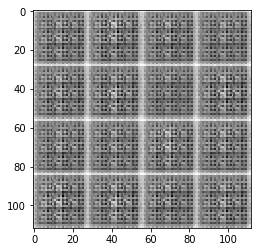

Epoch 1/2... Avg. Discriminator Loss: 2.5302... Avg. Generator Loss: 4.9891


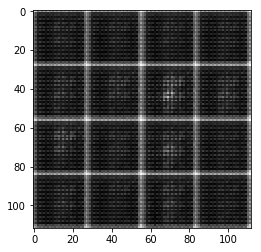

Epoch 1/2... Avg. Discriminator Loss: 1.0570... Avg. Generator Loss: 2.1695


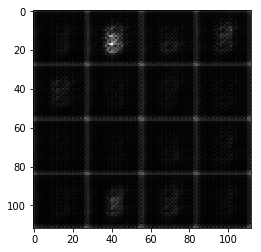

Epoch 1/2... Avg. Discriminator Loss: 1.0176... Avg. Generator Loss: 3.1100


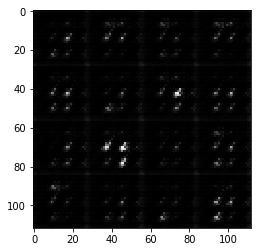

Epoch 1/2... Avg. Discriminator Loss: 1.1025... Avg. Generator Loss: 2.3787


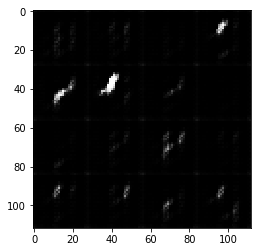

Epoch 1/2... Avg. Discriminator Loss: 1.2238... Avg. Generator Loss: 1.5028


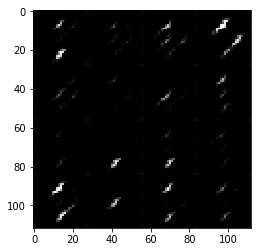

Epoch 1/2... Avg. Discriminator Loss: 1.0318... Avg. Generator Loss: 2.1512


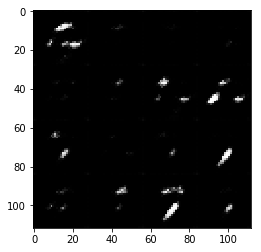

Epoch 1/2... Avg. Discriminator Loss: 0.8886... Avg. Generator Loss: 2.6846


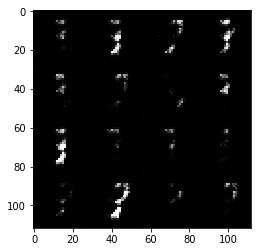

Epoch 1/2... Avg. Discriminator Loss: 0.9262... Avg. Generator Loss: 2.2133


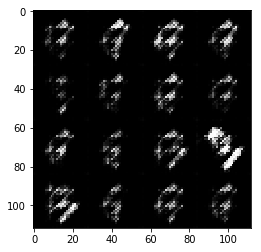

Epoch 1/2... Avg. Discriminator Loss: 1.2277... Avg. Generator Loss: 2.5315


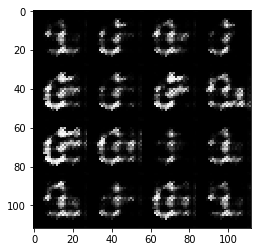

Epoch 1/2... Avg. Discriminator Loss: 0.4287... Avg. Generator Loss: 2.9462


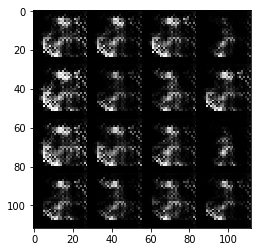

Epoch 1/2... Avg. Discriminator Loss: 0.3708... Avg. Generator Loss: 4.5305


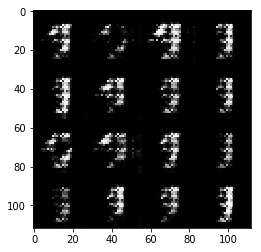

Epoch 1/2... Avg. Discriminator Loss: 0.7544... Avg. Generator Loss: 3.3818


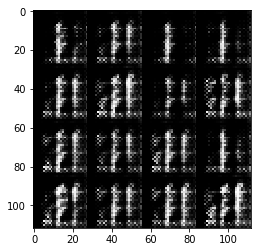

Epoch 1/2... Avg. Discriminator Loss: 0.8649... Avg. Generator Loss: 3.3823


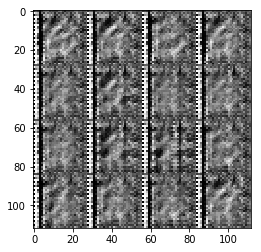

Epoch 1/2... Avg. Discriminator Loss: 0.8773... Avg. Generator Loss: 2.8594


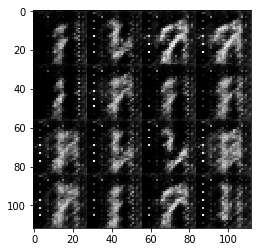

Epoch 1/2... Avg. Discriminator Loss: 1.0605... Avg. Generator Loss: 2.1915


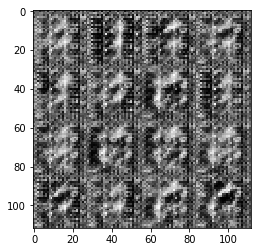

Epoch 1/2... Avg. Discriminator Loss: 1.0576... Avg. Generator Loss: 1.4179


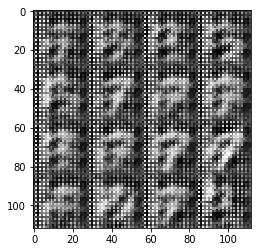

Epoch 1/2... Avg. Discriminator Loss: 0.9606... Avg. Generator Loss: 2.6913


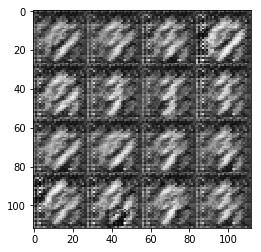

Epoch 1/2... Avg. Discriminator Loss: 0.3894... Avg. Generator Loss: 5.2413


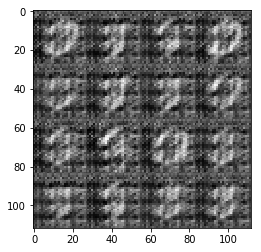

Epoch 1/2... Avg. Discriminator Loss: 1.1105... Avg. Generator Loss: 2.0262


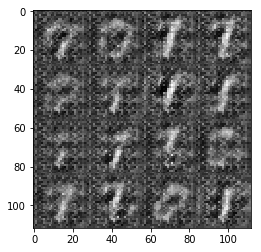

Epoch 1/2... Avg. Discriminator Loss: 0.7506... Avg. Generator Loss: 2.6105


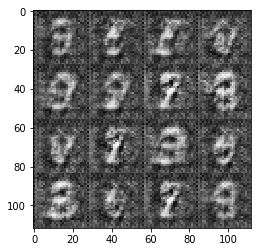

Epoch 1/2... Avg. Discriminator Loss: 0.9656... Avg. Generator Loss: 2.2516


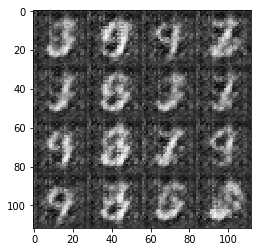

Epoch 1/2... Avg. Discriminator Loss: 1.1869... Avg. Generator Loss: 2.1544


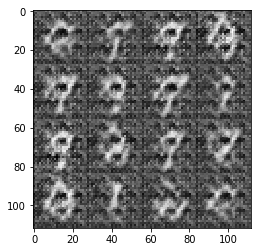

Epoch 1/2... Avg. Discriminator Loss: 0.7740... Avg. Generator Loss: 2.0979


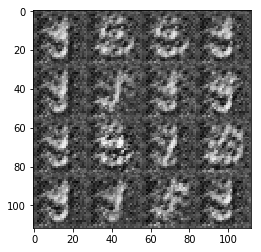

Epoch 1/2... Avg. Discriminator Loss: 0.6034... Avg. Generator Loss: 2.3919


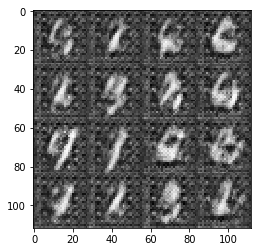

Epoch 1/2... Avg. Discriminator Loss: 0.8330... Avg. Generator Loss: 3.1525


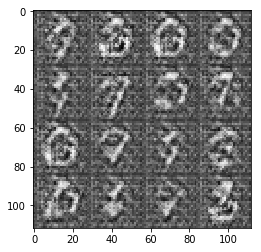

Epoch 1/2... Avg. Discriminator Loss: 0.7251... Avg. Generator Loss: 2.1294


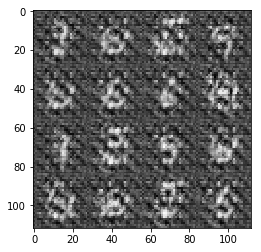

Epoch 1/2... Avg. Discriminator Loss: 1.0167... Avg. Generator Loss: 2.2404


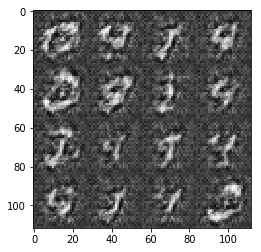

Epoch 1/2... Avg. Discriminator Loss: 0.6270... Avg. Generator Loss: 1.9987


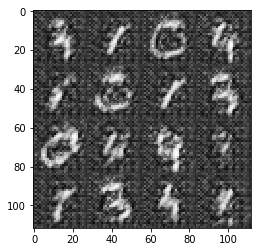

Epoch 1/2... Avg. Discriminator Loss: 0.9270... Avg. Generator Loss: 3.7116


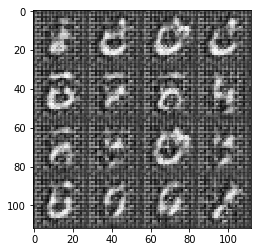

Epoch 1/2... Avg. Discriminator Loss: 1.0772... Avg. Generator Loss: 1.5223


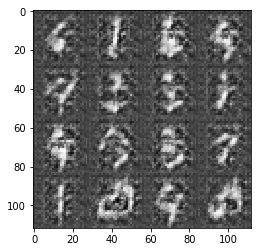

Epoch 1/2... Avg. Discriminator Loss: 0.7119... Avg. Generator Loss: 1.8283


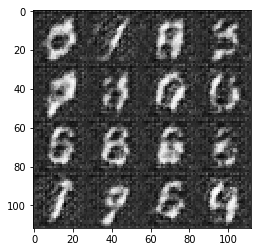

Epoch 1/2... Avg. Discriminator Loss: 1.0973... Avg. Generator Loss: 2.5318


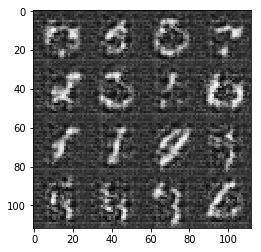

Epoch 1/2... Avg. Discriminator Loss: 0.6947... Avg. Generator Loss: 1.5103


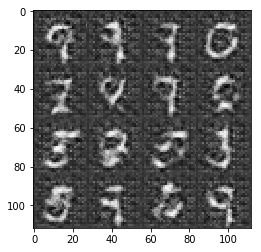

Epoch 1/2... Avg. Discriminator Loss: 1.0271... Avg. Generator Loss: 1.6854


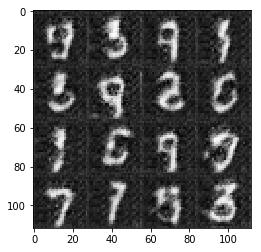

Epoch 1/2... Avg. Discriminator Loss: 1.0270... Avg. Generator Loss: 2.0618


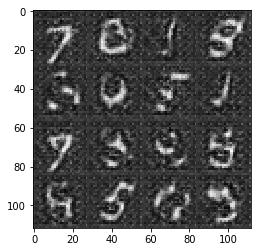

Epoch 1/2... Avg. Discriminator Loss: 0.6153... Avg. Generator Loss: 2.0257


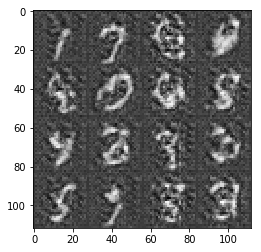

Epoch 1/2... Avg. Discriminator Loss: 0.5442... Avg. Generator Loss: 2.9545


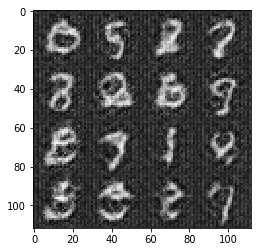

Epoch 1/2... Avg. Discriminator Loss: 0.7715... Avg. Generator Loss: 2.0973


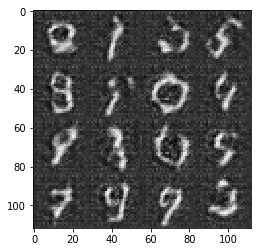

Epoch 1/2... Avg. Discriminator Loss: 0.9072... Avg. Generator Loss: 2.1210


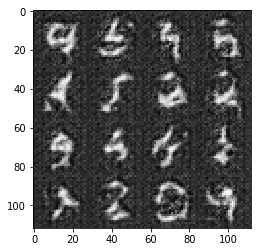

Epoch 1/2... Avg. Discriminator Loss: 0.6348... Avg. Generator Loss: 2.0281


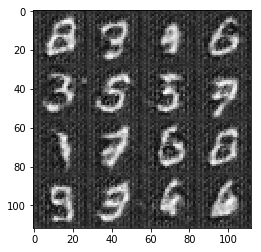

Epoch 1/2... Avg. Discriminator Loss: 1.1526... Avg. Generator Loss: 1.9691


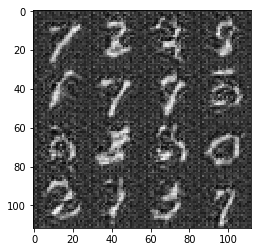

Epoch 1/2... Avg. Discriminator Loss: 0.7008... Avg. Generator Loss: 1.8596


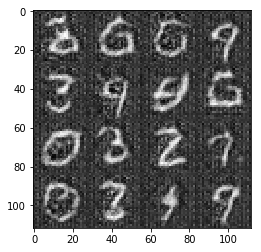

Epoch 1/2... Avg. Discriminator Loss: 0.8179... Avg. Generator Loss: 2.5274


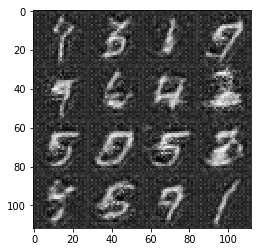

Epoch 1/2... Avg. Discriminator Loss: 0.6551... Avg. Generator Loss: 2.7330


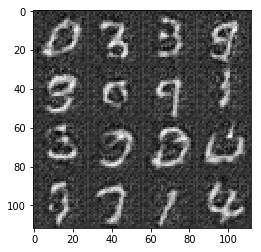

Epoch 1/2... Avg. Discriminator Loss: 0.8140... Avg. Generator Loss: 2.1263


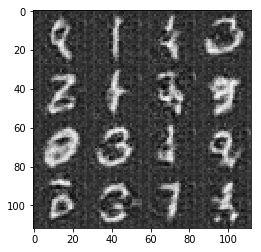

Epoch 1/2... Avg. Discriminator Loss: 1.0436... Avg. Generator Loss: 2.5856


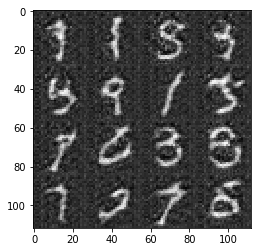

Epoch 2/2... Avg. Discriminator Loss: 0.4985... Avg. Generator Loss: 2.4853


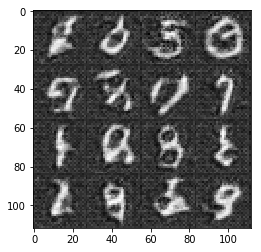

Epoch 2/2... Avg. Discriminator Loss: 1.0055... Avg. Generator Loss: 2.2252


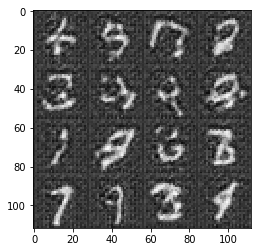

Epoch 2/2... Avg. Discriminator Loss: 0.6786... Avg. Generator Loss: 2.0849


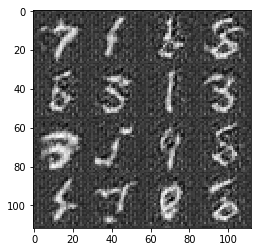

Epoch 2/2... Avg. Discriminator Loss: 0.4774... Avg. Generator Loss: 3.1465


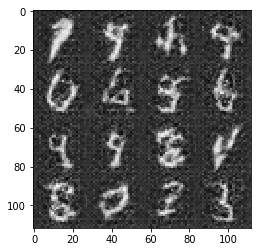

Epoch 2/2... Avg. Discriminator Loss: 0.5291... Avg. Generator Loss: 3.9769


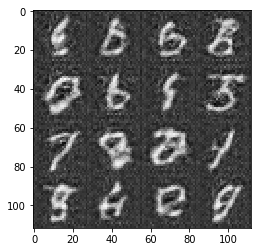

Epoch 2/2... Avg. Discriminator Loss: 1.0370... Avg. Generator Loss: 2.1544


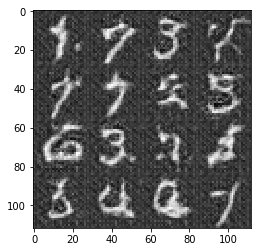

Epoch 2/2... Avg. Discriminator Loss: 0.7678... Avg. Generator Loss: 2.2456


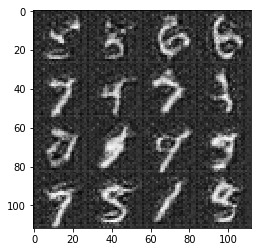

Epoch 2/2... Avg. Discriminator Loss: 0.8742... Avg. Generator Loss: 2.6174


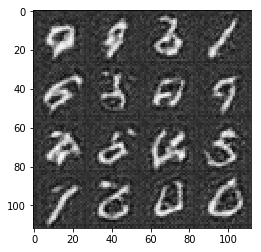

Epoch 2/2... Avg. Discriminator Loss: 0.9091... Avg. Generator Loss: 1.9616


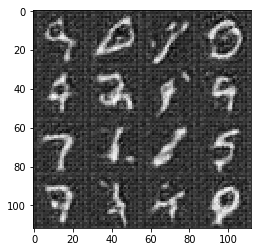

Epoch 2/2... Avg. Discriminator Loss: 1.0577... Avg. Generator Loss: 1.8860


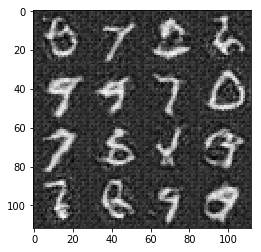

Epoch 2/2... Avg. Discriminator Loss: 0.7496... Avg. Generator Loss: 1.7546


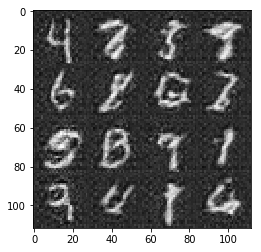

Epoch 2/2... Avg. Discriminator Loss: 0.5593... Avg. Generator Loss: 2.4245


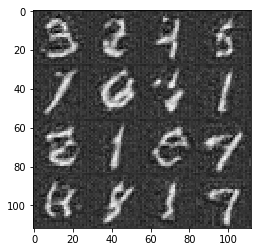

Epoch 2/2... Avg. Discriminator Loss: 0.8018... Avg. Generator Loss: 2.3597


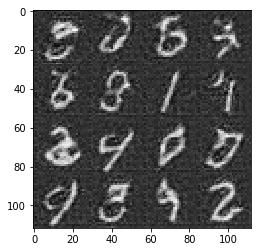

Epoch 2/2... Avg. Discriminator Loss: 0.4701... Avg. Generator Loss: 3.2586


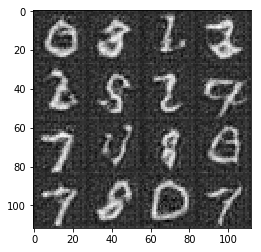

Epoch 2/2... Avg. Discriminator Loss: 1.1619... Avg. Generator Loss: 2.1858


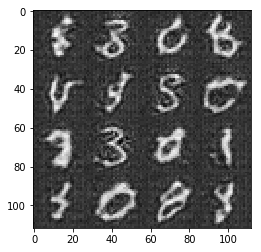

Epoch 2/2... Avg. Discriminator Loss: 0.9018... Avg. Generator Loss: 1.5027


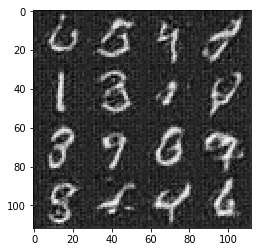

Epoch 2/2... Avg. Discriminator Loss: 0.8517... Avg. Generator Loss: 2.1971


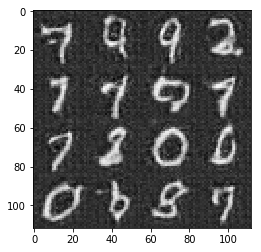

Epoch 2/2... Avg. Discriminator Loss: 1.1058... Avg. Generator Loss: 1.4952


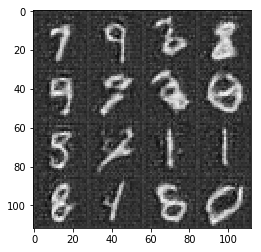

Epoch 2/2... Avg. Discriminator Loss: 0.8714... Avg. Generator Loss: 1.4050


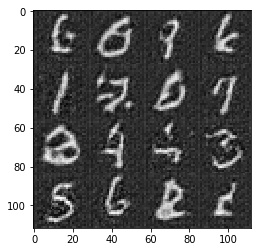

Epoch 2/2... Avg. Discriminator Loss: 0.8532... Avg. Generator Loss: 1.6747


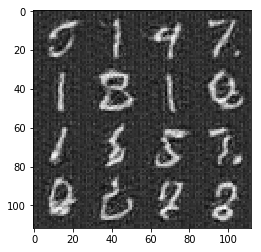

Epoch 2/2... Avg. Discriminator Loss: 0.6270... Avg. Generator Loss: 1.8030


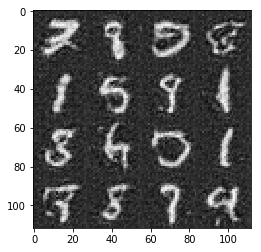

Epoch 2/2... Avg. Discriminator Loss: 0.4991... Avg. Generator Loss: 2.5615


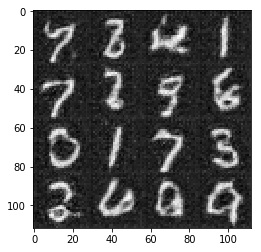

Epoch 2/2... Avg. Discriminator Loss: 1.0262... Avg. Generator Loss: 2.6940


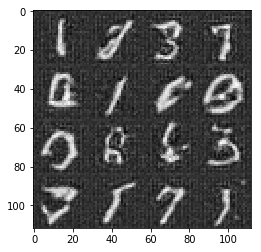

Epoch 2/2... Avg. Discriminator Loss: 0.8313... Avg. Generator Loss: 1.6211


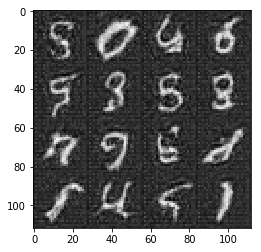

Epoch 2/2... Avg. Discriminator Loss: 0.6181... Avg. Generator Loss: 2.2985


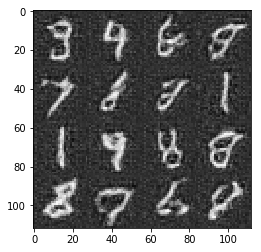

Epoch 2/2... Avg. Discriminator Loss: 0.4604... Avg. Generator Loss: 3.0127


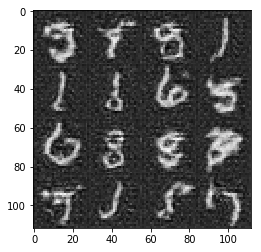

Epoch 2/2... Avg. Discriminator Loss: 0.4313... Avg. Generator Loss: 3.5971


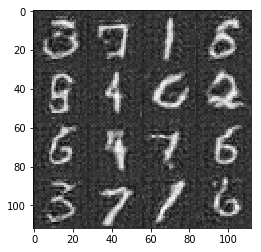

Epoch 2/2... Avg. Discriminator Loss: 1.3541... Avg. Generator Loss: 1.9163


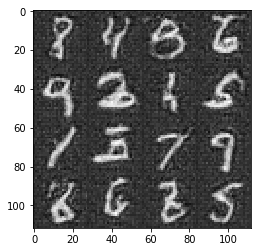

Epoch 2/2... Avg. Discriminator Loss: 0.7139... Avg. Generator Loss: 1.8655


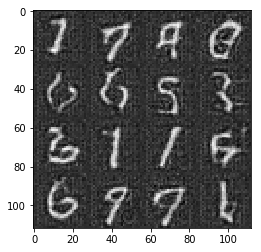

Epoch 2/2... Avg. Discriminator Loss: 1.1062... Avg. Generator Loss: 2.0972


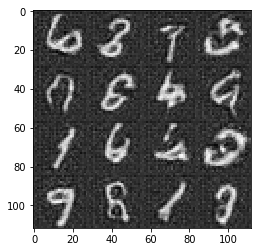

Epoch 2/2... Avg. Discriminator Loss: 0.7419... Avg. Generator Loss: 1.9634


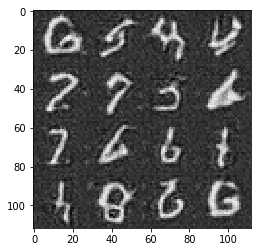

Epoch 2/2... Avg. Discriminator Loss: 1.0716... Avg. Generator Loss: 1.7957


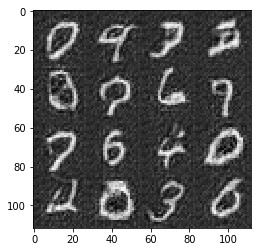

Epoch 2/2... Avg. Discriminator Loss: 0.5977... Avg. Generator Loss: 1.8287


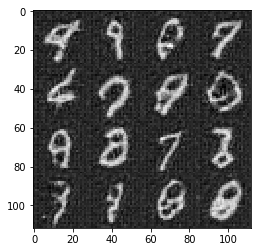

Epoch 2/2... Avg. Discriminator Loss: 0.7706... Avg. Generator Loss: 2.4652


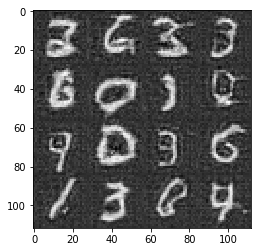

Epoch 2/2... Avg. Discriminator Loss: 1.0875... Avg. Generator Loss: 1.4443


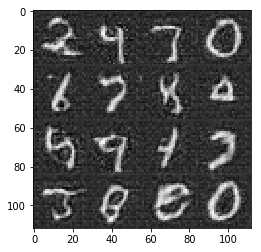

Epoch 2/2... Avg. Discriminator Loss: 1.0030... Avg. Generator Loss: 1.4746


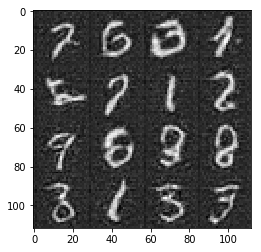

Epoch 2/2... Avg. Discriminator Loss: 0.7129... Avg. Generator Loss: 1.9730


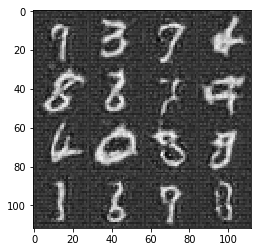

Epoch 2/2... Avg. Discriminator Loss: 1.2331... Avg. Generator Loss: 1.8310


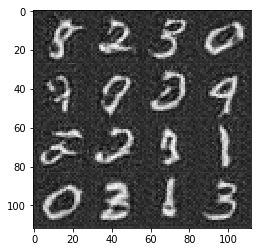

Epoch 2/2... Avg. Discriminator Loss: 0.8531... Avg. Generator Loss: 1.6030


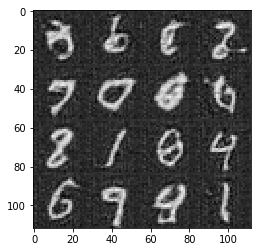

Epoch 2/2... Avg. Discriminator Loss: 0.7615... Avg. Generator Loss: 1.6955


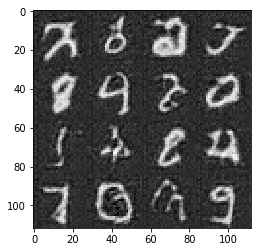

Epoch 2/2... Avg. Discriminator Loss: 0.6738... Avg. Generator Loss: 2.1835


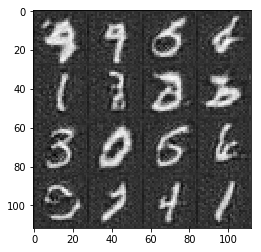

Epoch 2/2... Avg. Discriminator Loss: 0.9192... Avg. Generator Loss: 2.1277


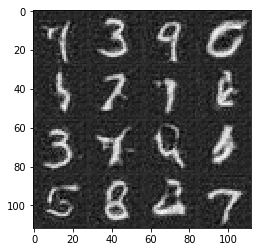

Epoch 2/2... Avg. Discriminator Loss: 0.9313... Avg. Generator Loss: 1.5813


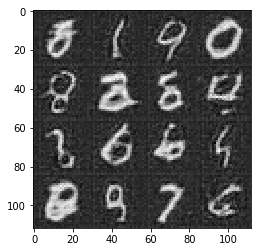

Epoch 2/2... Avg. Discriminator Loss: 0.8435... Avg. Generator Loss: 1.4170


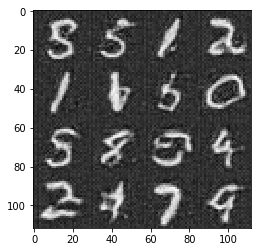

Epoch 2/2... Avg. Discriminator Loss: 0.8384... Avg. Generator Loss: 1.8615


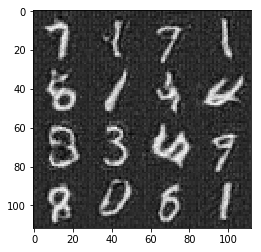

Epoch 2/2... Avg. Discriminator Loss: 0.9665... Avg. Generator Loss: 1.5963


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

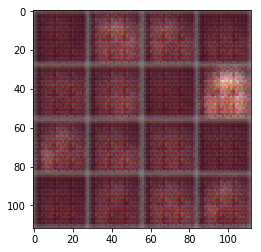

Epoch 1/1... Avg. Discriminator Loss: 2.4350... Avg. Generator Loss: 2.5122


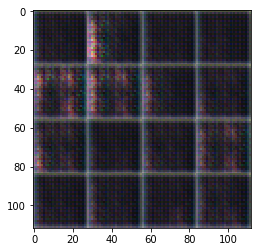

Epoch 1/1... Avg. Discriminator Loss: 1.4327... Avg. Generator Loss: 1.9490


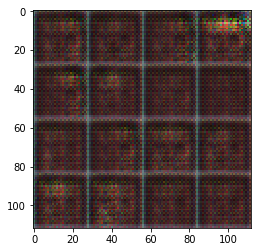

Epoch 1/1... Avg. Discriminator Loss: 1.0596... Avg. Generator Loss: 2.1856


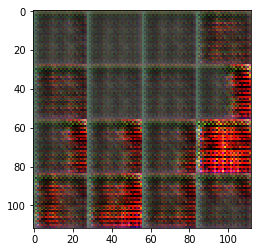

Epoch 1/1... Avg. Discriminator Loss: 0.8440... Avg. Generator Loss: 2.2905


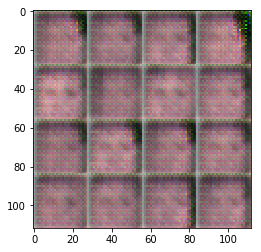

Epoch 1/1... Avg. Discriminator Loss: 0.7584... Avg. Generator Loss: 2.6664


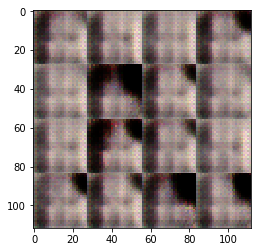

Epoch 1/1... Avg. Discriminator Loss: 1.2002... Avg. Generator Loss: 2.3482


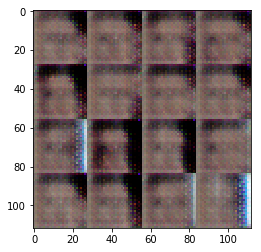

Epoch 1/1... Avg. Discriminator Loss: 1.1284... Avg. Generator Loss: 1.5868


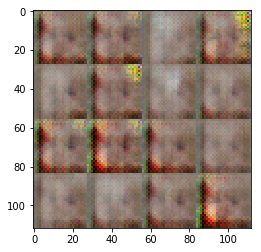

Epoch 1/1... Avg. Discriminator Loss: 1.0450... Avg. Generator Loss: 1.4223


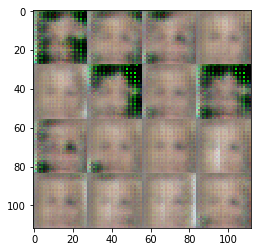

Epoch 1/1... Avg. Discriminator Loss: 0.9551... Avg. Generator Loss: 1.8534


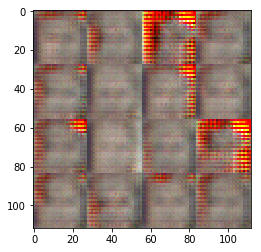

Epoch 1/1... Avg. Discriminator Loss: 0.8140... Avg. Generator Loss: 2.1112


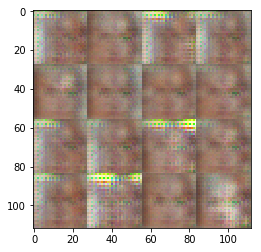

Epoch 1/1... Avg. Discriminator Loss: 1.0605... Avg. Generator Loss: 1.5362


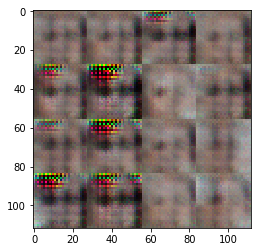

Epoch 1/1... Avg. Discriminator Loss: 1.2192... Avg. Generator Loss: 2.0787


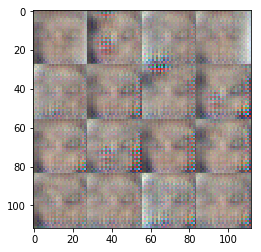

Epoch 1/1... Avg. Discriminator Loss: 0.9331... Avg. Generator Loss: 1.4549


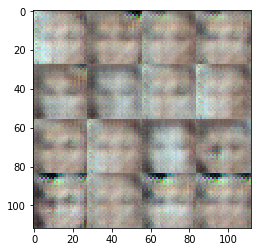

Epoch 1/1... Avg. Discriminator Loss: 1.6436... Avg. Generator Loss: 1.3398


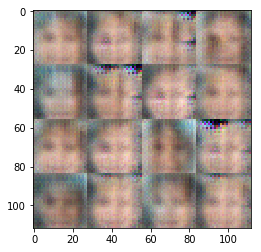

Epoch 1/1... Avg. Discriminator Loss: 1.2848... Avg. Generator Loss: 0.9224


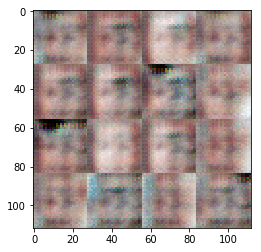

Epoch 1/1... Avg. Discriminator Loss: 1.2899... Avg. Generator Loss: 0.8892


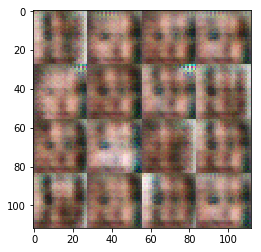

Epoch 1/1... Avg. Discriminator Loss: 1.3005... Avg. Generator Loss: 0.9176


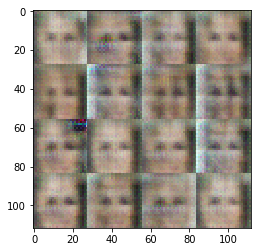

Epoch 1/1... Avg. Discriminator Loss: 1.2105... Avg. Generator Loss: 1.0928


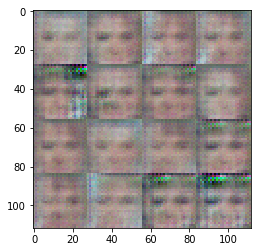

Epoch 1/1... Avg. Discriminator Loss: 1.2156... Avg. Generator Loss: 1.1892


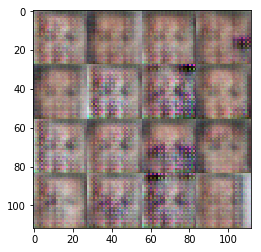

Epoch 1/1... Avg. Discriminator Loss: 0.9018... Avg. Generator Loss: 1.6182


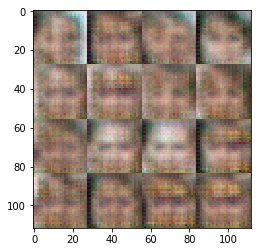

Epoch 1/1... Avg. Discriminator Loss: 1.3225... Avg. Generator Loss: 1.4860


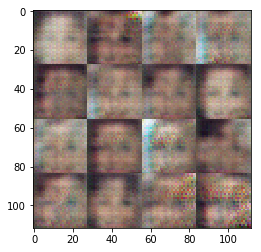

Epoch 1/1... Avg. Discriminator Loss: 1.2625... Avg. Generator Loss: 1.1491


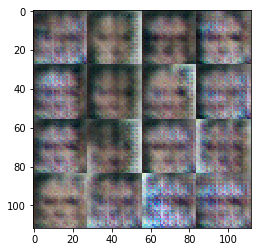

Epoch 1/1... Avg. Discriminator Loss: 1.1130... Avg. Generator Loss: 1.1544


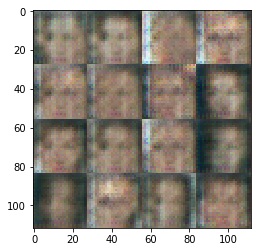

Epoch 1/1... Avg. Discriminator Loss: 1.1836... Avg. Generator Loss: 1.3330


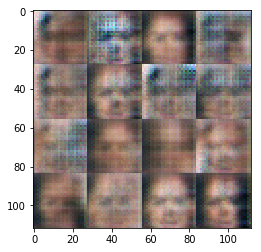

Epoch 1/1... Avg. Discriminator Loss: 1.0454... Avg. Generator Loss: 1.2366


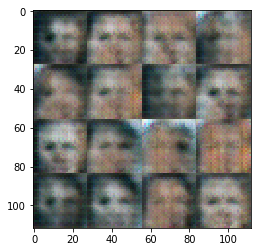

Epoch 1/1... Avg. Discriminator Loss: 1.1596... Avg. Generator Loss: 1.4710


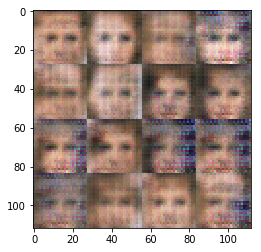

Epoch 1/1... Avg. Discriminator Loss: 1.1635... Avg. Generator Loss: 1.4808


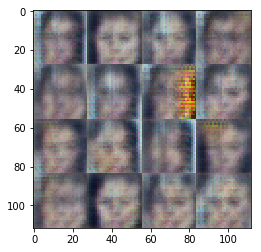

Epoch 1/1... Avg. Discriminator Loss: 1.0809... Avg. Generator Loss: 1.3889


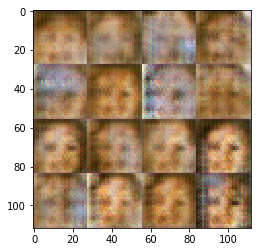

Epoch 1/1... Avg. Discriminator Loss: 0.9890... Avg. Generator Loss: 1.5809


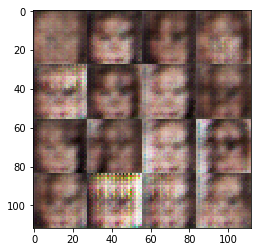

Epoch 1/1... Avg. Discriminator Loss: 0.9519... Avg. Generator Loss: 1.7241


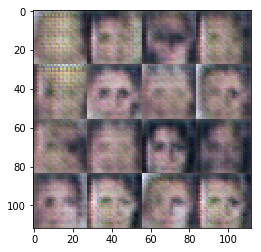

Epoch 1/1... Avg. Discriminator Loss: 1.0650... Avg. Generator Loss: 1.5282


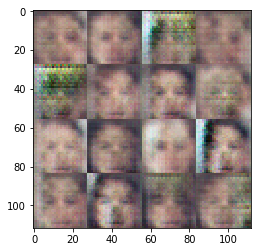

Epoch 1/1... Avg. Discriminator Loss: 1.2118... Avg. Generator Loss: 1.3882


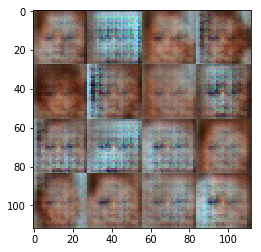

Epoch 1/1... Avg. Discriminator Loss: 1.0996... Avg. Generator Loss: 1.5089


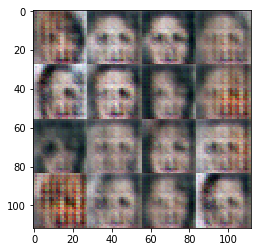

Epoch 1/1... Avg. Discriminator Loss: 1.0379... Avg. Generator Loss: 1.4742


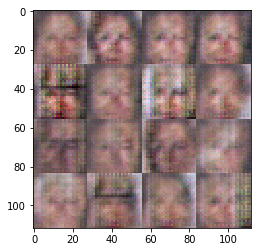

Epoch 1/1... Avg. Discriminator Loss: 1.0233... Avg. Generator Loss: 1.6163


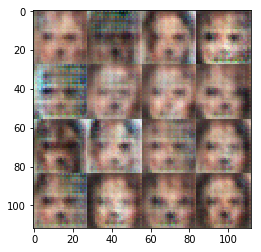

Epoch 1/1... Avg. Discriminator Loss: 1.0240... Avg. Generator Loss: 1.8137


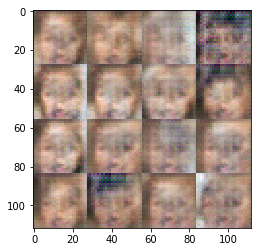

Epoch 1/1... Avg. Discriminator Loss: 0.9972... Avg. Generator Loss: 1.5869


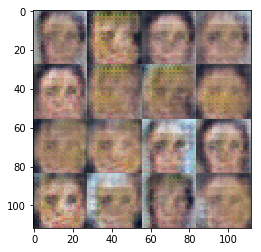

Epoch 1/1... Avg. Discriminator Loss: 1.1622... Avg. Generator Loss: 1.5721


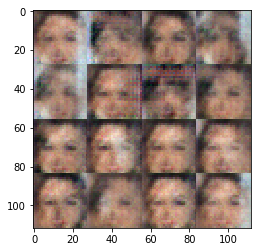

Epoch 1/1... Avg. Discriminator Loss: 1.0849... Avg. Generator Loss: 1.5893


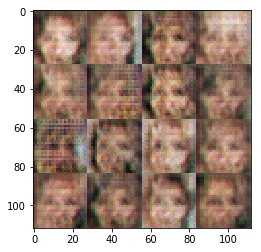

Epoch 1/1... Avg. Discriminator Loss: 1.0105... Avg. Generator Loss: 1.5496


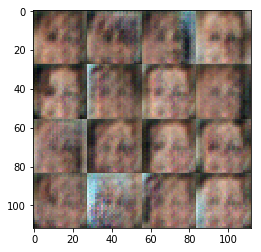

Epoch 1/1... Avg. Discriminator Loss: 0.9118... Avg. Generator Loss: 1.7236


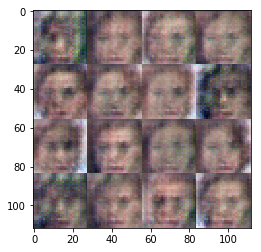

Epoch 1/1... Avg. Discriminator Loss: 1.2403... Avg. Generator Loss: 1.7941


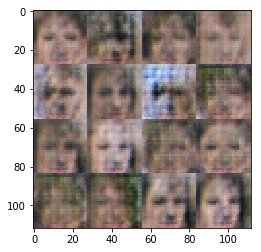

Epoch 1/1... Avg. Discriminator Loss: 0.9027... Avg. Generator Loss: 1.8472


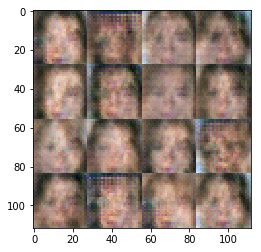

Epoch 1/1... Avg. Discriminator Loss: 0.9805... Avg. Generator Loss: 1.9762


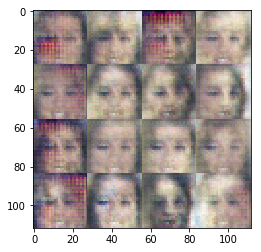

Epoch 1/1... Avg. Discriminator Loss: 1.0605... Avg. Generator Loss: 1.6027


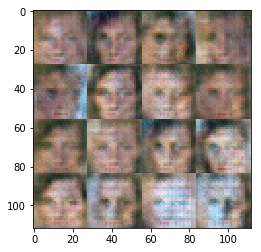

Epoch 1/1... Avg. Discriminator Loss: 1.0708... Avg. Generator Loss: 1.6354


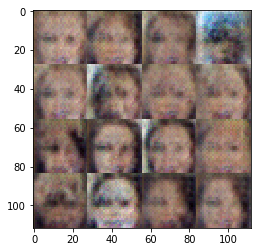

Epoch 1/1... Avg. Discriminator Loss: 0.8683... Avg. Generator Loss: 1.5523


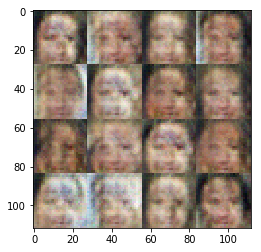

Epoch 1/1... Avg. Discriminator Loss: 1.1739... Avg. Generator Loss: 1.6159


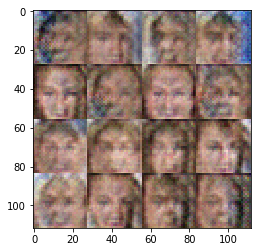

Epoch 1/1... Avg. Discriminator Loss: 0.9797... Avg. Generator Loss: 1.3274


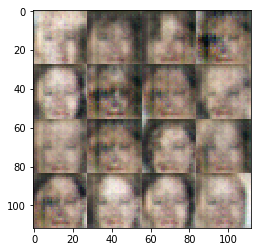

Epoch 1/1... Avg. Discriminator Loss: 1.1054... Avg. Generator Loss: 1.6044


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.